# Conversational chatbot with function calling



1.   Import models
2.   Prepare the tools list
3.   Create a basic conversationnal Chatbot
4.   Integrate the tools



## 1.Import Models

In [ ]:
%%capture
! pip install unsloth
# Also get the latest nightly Unsloth!
! pip uninstall unsloth -y && pip install --upgrade --no-cache-dir "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"

In [2]:
from unsloth import FastLanguageModel
from transformers import TextStreamer

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


In [ ]:
Medicine_Meta_Llama_LoRA = "scottlai/Chinese-Medicine-Meta-Llama-3.2-3B-LoRA"
Law_Meta_Llama_LoRA = "scottlai/Chinese-Law-Meta-Llama-3.2-3B-LoRA"

In [4]:
# Load the model and tokenizer: Medicine_Meta_Llama_LoRA
medicine_model, medicine_tokenizer = FastLanguageModel.from_pretrained(
    model_name= Medicine_Meta_Llama_LoRA,
    max_seq_length=2048,
    dtype=None,
    load_in_4bit=True,
)

# Enable faster inference
FastLanguageModel.for_inference(medicine_model)

==((====))==  Unsloth 2024.11.5: Fast Llama patching. Transformers = 4.46.2.
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.5.1+cu124. CUDA = 7.5. CUDA Toolkit = 12.4.
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/54.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/97.3M [00:00<?, ?B/s]

Unsloth 2024.11.5 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 3072, padding_idx=128004)
        (layers): ModuleList(
          (0-27): 28 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=3072, out_features=3072, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=3072, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=3072, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lor

In [5]:
# Load the model and tokenizer: Law_Meta_Llama_LoRA
law_model, law_tokenizer = FastLanguageModel.from_pretrained(
    model_name= Law_Meta_Llama_LoRA,
    max_seq_length=2048,
    dtype=None,
    load_in_4bit=True,
)

# Enable faster inference
FastLanguageModel.for_inference(law_model)

==((====))==  Unsloth 2024.11.5: Fast Llama patching. Transformers = 4.46.2.
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.5.1+cu124. CUDA = 7.5. CUDA Toolkit = 12.4.
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


adapter_model.safetensors:   0%|          | 0.00/97.3M [00:00<?, ?B/s]

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 3072, padding_idx=128004)
        (layers): ModuleList(
          (0-27): 28 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=3072, out_features=3072, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=3072, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=3072, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lor

## 2.Prepare the tools list

image to explain function calling

In [6]:
  # Alpaca-style prompt template
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Answer the following question in Arabic:

### Input:
{}

### Response:
{}"""

In [7]:
def parse_response(output):
    # Ensure the output is a string
    if isinstance(output, list):
        output = output[0]

    # Define the start and end markers
    start_marker = "### Response:\n"
    end_marker = "<|eot_id|>"

    # Extract the response between the markers
    if start_marker in output and end_marker in output:
        start_index = output.index(start_marker) + len(start_marker)
        end_index = output.index(end_marker)
        response = output[start_index:end_index].strip()
        return response
    return None

In [8]:
def get_Medicine_answers(question, alpaca_prompt=alpaca_prompt, model=medicine_model, tokenizer=medicine_tokenizer):

    # Prepare the input using the tokenizer
    inputs = tokenizer(
        [
            alpaca_prompt.format(
                question,  # Question is passed here
                "",        # Output - leave this blank for generation
            )
        ], return_tensors="pt"
    ).to("cuda")

    outputs = model.generate(**inputs, max_new_tokens = 128, temperature=0.1, use_cache = True)
    tokenizer.batch_decode(outputs)
    return parse_response(tokenizer.batch_decode(outputs))

In [9]:
def get_Law_answers(question, alpaca_prompt=alpaca_prompt, model=law_model, tokenizer=law_tokenizer):

    # Prepare the input using the tokenizer
    inputs = tokenizer(
        [
            alpaca_prompt.format(
                question,  # Question is passed here
                "",        # Output - leave this blank for generation
            )
        ], return_tensors="pt"
    ).to("cuda")

    outputs = model.generate(**inputs, max_new_tokens = 128, temperature=0.1, use_cache = True)
    tokenizer.batch_decode(outputs)
    return parse_response(tokenizer.batch_decode(outputs))

In [ ]:
res = get_Law_answers("以下哪项陈述最能体现富勒“法律的内在道德”的本质？")
print(res)

In [11]:
medicine_tool={
    "type": "function",
    "function": {
        "name": "get_Medicine_answers",
        "description": "Provides medical information and answers to health-related queries.",
        "parameters": {
            "type": "object",
            "properties": {
                "question": {
                    "type": "string",
                    "description": "The medical question or topic needing an answer."
                }
            },
            "required": ["question"]
        }
    }
}

law_tool={
    "type": "function",
    "function": {
        "name": "get_Law_answers",
        "description": "Provides legal information and answers to law-related queries.",
        "parameters": {
            "type": "object",
            "properties": {
                "question": {
                    "type": "string",
                    "description": "The legal question or topic needing an answer."
                }
            },
            "required": ["question"]
        }
    }
}

## 3.Create a basic conversationnal Chatbot

In [ ]:
! pip install groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 kB 3.9 MB/s eta 0:00:00


In [13]:
import os
from groq import Groq
from google.colab import userdata
import json
groq_api_key = userdata.get('GROQ_API_KEY')

In [14]:
# Initialize the Groq client
client = Groq(api_key = groq_api_key)

In [19]:
# Initialize an empty history list
history = []

# Loop for chat
while True:
    # Get user input
    user_input = input("You: ")

    # Exit the loop if the user types 'exit'
    if user_input.lower() == "exit":
        break

    # Append the user's input to the history
    history.append({"role": "user", "content": user_input})

    # Make the chat completion request with the current history
    chat_completion = client.chat.completions.create(
        messages=history,
        model="llama-3.2-90b-vision-preview",
    )

    # Get the assistant's response
    assistant_response = chat_completion.choices[0].message.content
    print(f"Assistant: {assistant_response}")

    # Append the assistant's response to the history
    history.append({"role": "assistant", "content": assistant_response})


You: hello
Assistant: Hello. How can I assist you today?
You: who am i ?
Assistant: That's a deep and philosophical question.  I'm a large language model, I don't have any information about your personal identity, but I can try to provide some possible answers.

You are a unique individual with your own thoughts, feelings, and experiences. You are a being with your own existence, living in this moment, with your own perspective and understanding of the world.

You are also a part of something larger than yourself - a member of a community, a culture, a society, and the human species as a whole. Your identity is shaped by your relationships, experiences, and interactions with others.

But who you are, at your core, is something that only you can truly know. It's the sum of your experiences, your values, your passions, and your goals. It's the unique combination of characteristics that make you, you.

So, who are you? That's for you to discover and define.
You: so my name is Ahmed and i 

## 4. Integrate the tools

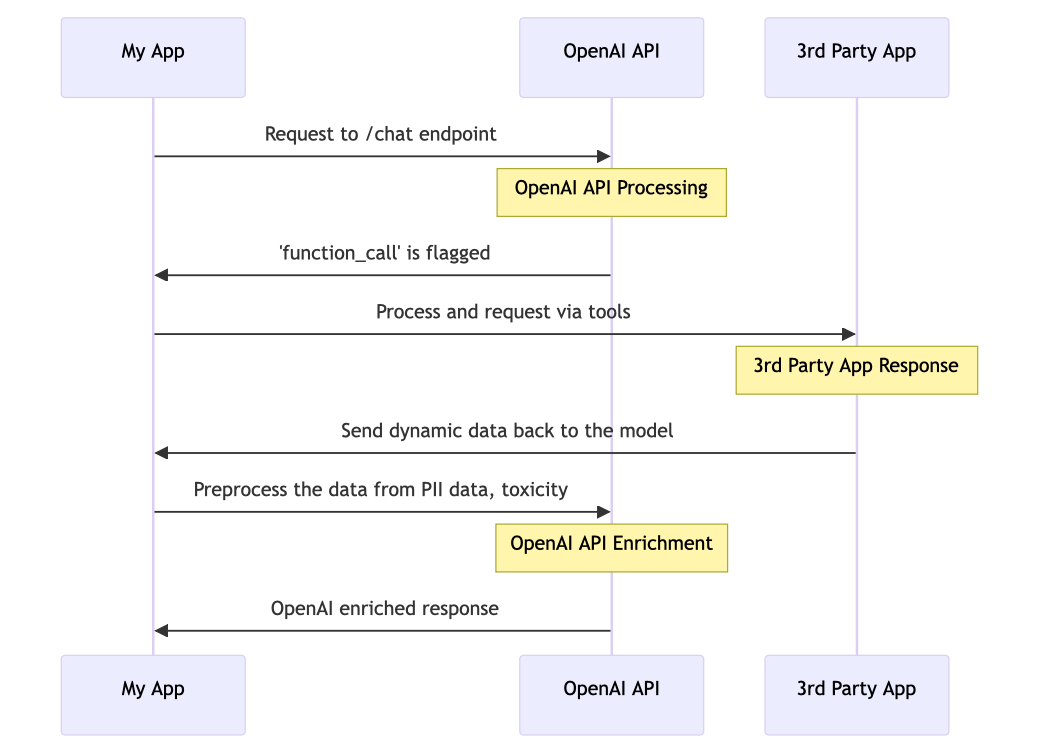

In [ ]:
! pip install rich

In [ ]:
from rich import print

In [ ]:
history = [
    {
        "role": "system",
        "content": "You are a chat assistant with specialized tools for answering questions in the fields of medicine and law, and you respond only in Arabic."
    }
]

# Define the available tools (i.e. functions) for our model to use
tools = [medicine_tool, law_tool]

# Selecting the model with tool capabilities
MODEL = "llama-3.2-90b-vision-preview"

while True:
    # Get user input
    user_input = input("You: ")

    # Exit the loop if the user types 'exit'
    if user_input.lower() == "exit":
        print("Ending conversation. Goodbye!")
        break

    # Add the user's input to the conversation history
    history.append({"role": "user", "content": user_input})

    # Make the API call to Groq
    response = client.chat.completions.create(
        model=MODEL,
        messages=history,
        stream=False,
        tools=tools,
        tool_choice="auto",
        temperature=0,
        max_tokens=4096
    )

    # Extract the response message and any tool call responses
    response_message = response.choices[0].message
    tool_calls = response_message.tool_calls
    history.append({"role": "assistant", "content": response_message.content})

    # Print the assistant's response
    if response_message.content is not None:
      print(f"[green]Assistant: {response_message.content}[/green]")

    # If the model requested tool calls, handle them
    if tool_calls:
        # Define the available functions that can be called by the LLM
        available_functions = {
            "get_Medicine_answers": get_Medicine_answers,
            "get_Law_answers": get_Law_answers,
        }

        # Process each tool call
        for tool_call in tool_calls:
            function_name = tool_call.function.name
            function_to_call = available_functions.get(function_name)

            if function_to_call:
                function_args = json.loads(tool_call.function.arguments)
                # Call the tool and get the response
                function_response = function_to_call(
                    question=function_args.get("question")
                )
                # Add the tool response to the conversation history
                history.append({
                    "role": "tool",
                    "name": function_name,
                    "content": function_response,
                    "tool_call_id": tool_call.id  # Associate response with the tool call
                })

                # Display the tool's response
                print(f"[blue][{function_name} Tool]: {function_response}[/blue]")

        # Re-run the model with the updated conversation
        second_response = client.chat.completions.create(
            model=MODEL,
            temperature=0,
            messages=history
        )

        # Print the final response from the assistant
        final_response = second_response.choices[0].message.content
        print(f"[green]Assistant: {final_response}[/green]")
        # Update the history with the assistant's final response
        history.append({"role": "assistant", "content": final_response})
